## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k, n_greater_50k = data.income.value_counts()

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

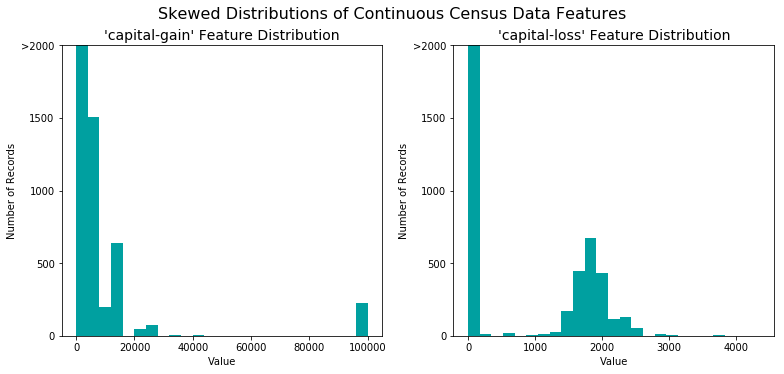

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

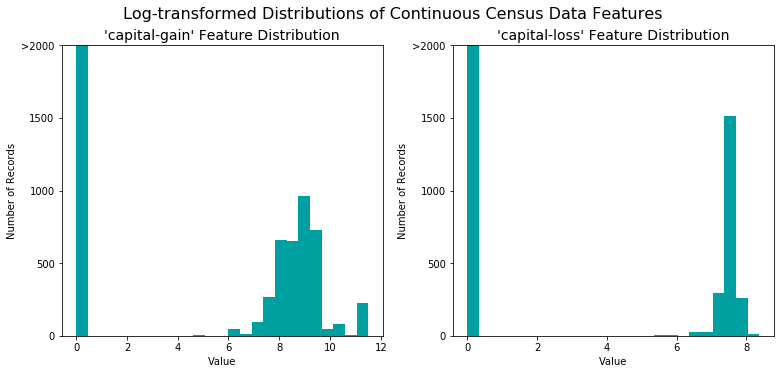

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

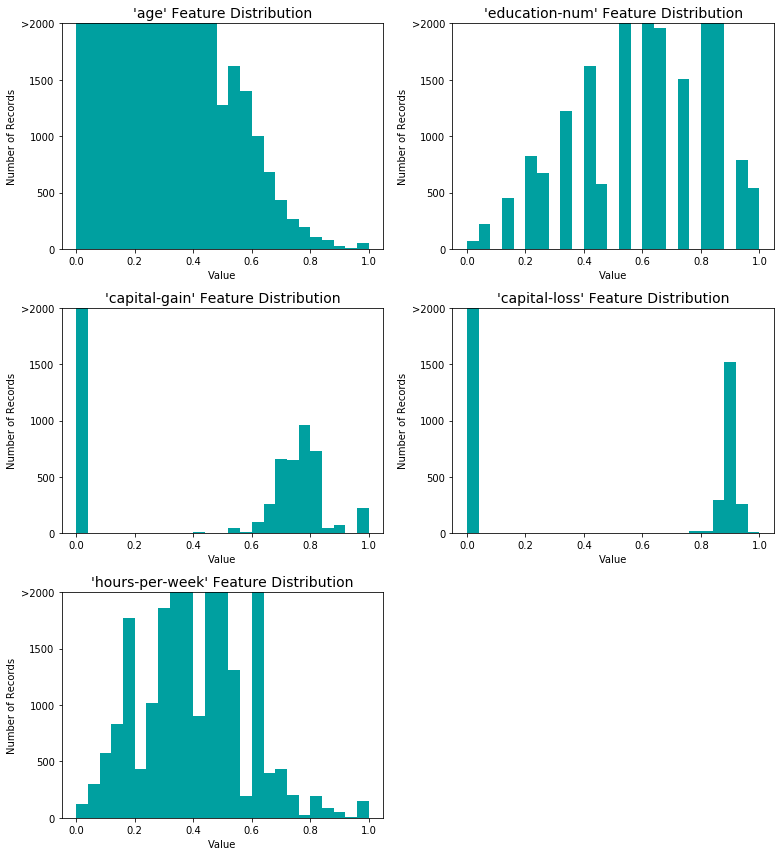

In [7]:
## After transform
fig = plt.figure(figsize=(11, 12))
for i, feature in enumerate(numerical):
    ax = fig.add_subplot(3, 2, i+1)
    ax.hist(features_log_minmax_transform[feature], bins=25, color = '#00A0A0')
    ax.set_title("'{}' Feature Distribution".format(feature), fontsize=14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])
    
fig.tight_layout()
fig.show()

### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [8]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K': 0, '>50K': 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [10]:
TP = np.sum(income) # Counting the ones as this is the naive case. 
                    # Note that 'income' is the 'income_raw' data encoded to numerical values done 
                    # in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# TODO: Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + .5**2) * (precision * recall) / (.5**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**
1. **Adaboost** is a Boosting type Ensemble Learning Method. In the industry, boosting algorithms have been used for the binary classification problem of face detection where the algorithm has to identify wheter a portion of an image is a face or background (https://en.wikipedia.org/wiki/Boosting_(machine_learning). One of the main strenghts of Adaboost is that it is a fast algorithm, agnostic to the classifier and less prone to overfitting. During the iterative training, it continuously gives more weight to missclassified labels to allow the classifier to focus on the harder cases which increases the overall model's performance. On the other hand, noisy data and outliers in the data can negatively impact the performance so data pre processing is important. Furthermore, if a complex model is used as the base classifier, this can lead to overfitting to the training data. In my opinion, this model is a good candidate for the problem as our dataset is large yet clean. Therefore we will be able to perform multiple quick trainining iterations to maximize our overall accuracy on the unseen testing data.

2. **Random Forest** can be used to improve personalization technology of Netflix (https://blog.udacity.com/2016/06/machine-learning-everywhere-netflix-personalized-medicine-fraud-prevention.html). Random Forest Classification is fairly good for training even small samples and can be easily parallelized in Python. Also, it shows good performance on many problems including non linear problems. However, randome forest model could easily end up with a forest that takes hundreds of megabytes of memory and is slow to evaluate. Also, to humans, random forest models are black box models that are very hard to interpret (i.e., not very readable). Random Forest models fail when there are rare outcomes or rare predictors, as the algorithm is based on bootstrap sampling. This makes it non-ideal if you are working with rare personality traits, high segmented customer behavior, or rare variants in genomics research. I think this model can make a good candidate for dataset is clean, and not too large. Also random forest runtimes are quit fast, and they can deal with rather unbalanced data which can be a big yes to our data from what we learn previous steps

3. **Gradient Boosting** is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function (https://en.wikipedia.org/wiki/Gradient_boosting). A great application of Gradient Boosting is anomaly detection in supervised learning settings where data is often highly unbalanced such as D A sequences, credit card transactions or cyber security (https://medium.com/@aravanshad/gradient-boosting-versus-random-forest-cfa3fa8f0d80). Since boosted trees are derived by optimizing an objective function, basically Gradient Bossting can be used to solve almost all objective function that we can write gradient out. This including things like ranking and poission regression, which Random Forest is harder to achieve. However, Gradient Boosting models are more sensitive to overfitting if the data is noisy and thus can fail. Furthermore, training generally takes longer because of the fact that trees are built sequentially. Due to the fact that Gradient Boosting model has usually three parameters - number of trees, depth of trees and learning rate, it is relatively harder to tune than other ensemble methods. As with Random Forest, data is clean and rather unbalanced, which Gradient Boosting can shine by strengthening the impact of the positive class.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


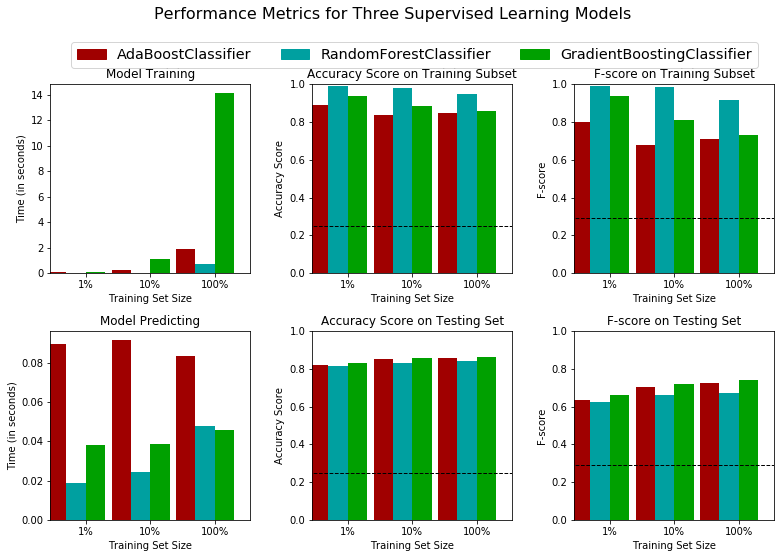

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = AdaBoostClassifier(random_state=543)
clf_B = RandomForestClassifier(random_state=543)
clf_C = GradientBoostingClassifier(random_state=543)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = X_train.shape[0]
samples_10 = X_train.shape[0] // 10
samples_1 = X_train.shape[0] // 100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:** I chose AdaBoostClassifier, RandomForestClassifier, and GradientBoostingClassifier models. Given running time, accuracy score, and F-score on test set when using the entire training data, **my answer to this question is Adaboost** model. As shown above, running time of adaboost for training is shorter than gradient boosting though a little longer than random forest. running time for prediction is longer than other two models, which is a catch, however, given that predicting doners does not require very quick prediction and it is actually not very long time, this factor is not very meaningful. Accuracy score is seemingly highest as well as F-score. One interesting point is RandomForestClassifier showed the best performance with training data set, however, it showed the worst accuracy and F-score with testing data set. This may imply that random forest model has strong tendency to overfit training set. 

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer** AdaBoost is a popular boosting technique which helps you combine multiple “weak classifiers” into a single “strong classifier”. A weak classifier is simply a classifier that performs poorly, but performs better than random guessing. A simple example might be classifying a person as male or female based on their height. You could say anyone over 5’ 9” is a male and anyone under that is a female. You’ll misclassify a lot of people that way, but your accuracy will still be greater than 50%. AdaBoost fits a sequence of weak learners on different weighted training data. That is, at each step, the model focus on wrongly classified elements and try harder to correctly assign them to the right group. The model repeats this operation until a limit is reached in the number of models or accuracy. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [13]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries# TODO:  
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=543)

# TODO: Create the parameters list you wish to tune
parameters = dict(n_estimators=[50,100,250,500,750],
                learning_rate=[1.5, 1, 0.1, 0.01])

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8668
Final F-score on the testing data: 0.7431


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.8576        |    0.8668       |
| F-score        |     0.7246        |    0.7431       |



**Answer:**
The optimized model's accuracy and F-score are respectively 0.8676 and 0.7448. These scores are better than the unoptimized model. The unoptimized model's accuracy and F-score are respectively 0.8576 and 0.7246. The accuracy and F-score also really improved compared to the naive predictor benchmarks. The naive predictor benchmarks's accuracy and F-score are respectively 0.2478 and 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**
1. Hours per week: because income is determined by hours of work times wage, it is a multiplier. Therefore, by definition, it plays an important role to determine how much a person can make
2. Age: Younger people are naturally less exprienced than the older and therefore paid less
3. Education level: People with higher education also have better chances of finding high-paid jobs and being promoted
4. occupation: the occupation should be a a major driver for income because you would expect laywer makes more money then receptionist.
5. Native country: People in first world countries, such as USA tend to earn more income that in other countries

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

In [14]:
features_log_minmax_transform.columns.values

array(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'], dtype=object)

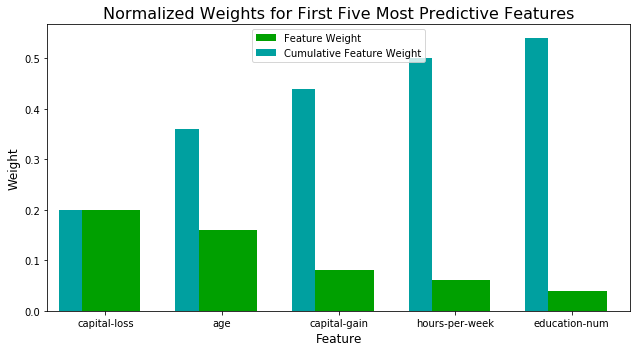

In [15]:
# TODO: Import a supervised learning model that has 'feature_importances_'
clf = AdaBoostClassifier(random_state=614)

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = clf.fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**
Capital-gain and capital-loss did not cross my mind. However, thinking about it, it makes sense because if you have big capital loss and gain, it means basically you have enough income to lose and gain - measure of income. Also, I guessed part correctly when it comes to education. I thought what degree you have plays an important role not how long because longer time of education does not always guarantee higher education level. I was correct about hours-per-week and age and the chart confirms my thoughts. Unlike my conjecture, native country did not contribute much to prediction. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8668
F-score on testing data: 0.7431

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.7047


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:** Accuracy and F-score of reduced data are lower than the optimal ones with all the features. I think it is due to the fact that even though those 5 features takes up lots of importance to data, those 5 are not enough to catch all the complexity of the data and therfore, their capability of generalization went down. If train time was a factor, reducing the number of features reduces the size of computation and thus will decrease the running time for training. All in all, in this case, loss in performance (accuracy and F-score) and improvement in training time are in a trade off relation

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

##Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [17]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding_donors.ipynb to html',
 '[NbConvertApp] Writing 497180 bytes to finding_donors.html']